In [1]:
import geopandas as gpd
import cartopy.feature as cfeature
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds
import ultraplot as uplt
import cartopy.crs as ccrs
import rasterio as rio
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

# 1000m pixels

In [2]:
new_york_2019 = rio.open('./Data/Yearly Images/as_satellite_comp_1000_2019.tif', 'r')
new_york_2020 = rio.open('./Data/Yearly Images/as_satellite_comp_1000_2020.tif', 'r')
new_york_2021 = rio.open('./Data/Yearly Images/as_satellite_comp_1000_2021.tif', 'r')
new_york_2022 = rio.open('./Data/Yearly Images/as_satellite_comp_1000_2022.tif', 'r')
new_york_2023 = rio.open('./Data/Yearly Images/as_satellite_comp_1000_2023.tif', 'r')
#aerial = rio.open('./Data/Yearly Images/upscaled_aerial_survey_2021.tif', 'r')

In [3]:
new_york_2023.count

5

In [4]:
dest_crs = ccrs.AlbersEqualArea(central_longitude=-76.0, central_latitude=42.0,)

def prepare_for_viz(raster_file, dest_crs):
    transform, width, height = calculate_default_transform(
        raster_file.crs, dest_crs, raster_file.width, raster_file.height, *raster_file.bounds)
    
    new_image, new_transform = reproject(
        source=raster_file.read(),
        src_transform=raster_file.transform,
        src_crs=raster_file.crs,
        dst_crs=dest_crs,
        resampling=Resampling.nearest,
        dst_nodata=np.nan)

    new_image = new_image.transpose([1, 2, 0])
    new_bounds = array_bounds(new_image.shape[0], new_image.shape[1], new_transform)
    
    return new_image, new_bounds

# 2019
image_2019, bounds_2019 = prepare_for_viz(new_york_2019, dest_crs)

# 2020
image_2020, bounds_2020 = prepare_for_viz(new_york_2020, dest_crs)

# 2021
image_2021, bounds_2021 = prepare_for_viz(new_york_2021, dest_crs)

# 2022
image_2022, bounds_2022 = prepare_for_viz(new_york_2022, dest_crs)

# 2023
image_2023, bounds_2023 = prepare_for_viz(new_york_2023, dest_crs)

In [5]:
def add_raster_data(ax, image, bounds, year, crs, vmin, vmax, cmap):
    m = ax.imshow(image, cmap=cmap, levels=np.linspace(vmin, vmax, 11), transform=crs,
                  extent=[bounds[0], bounds[2], bounds[1], bounds[3]])
    ax.format(grid=False, facecolor='white', title=str(year))
    ax.set_extent([-80, -71.7, 40.3, 45], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES)
    
    return m

In [6]:
def classify(image, threshold):
    image_thresh = image.copy()
    image_thresh = np.greater(image, threshold, out=image_thresh, where=~np.isnan(image))
    return image_thresh

## 2-mask

In [7]:
cutoff = 0.1

threshold_2019 = classify(image_2019[:, :, 0], cutoff)
threshold_2020 = classify(image_2020[:, :, 0], cutoff)
threshold_2021 = classify(image_2021[:, :, 0], cutoff)
threshold_2022 = classify(image_2022[:, :, 0], cutoff)
threshold_2023 = classify(image_2023[:, :, 0], cutoff)

In [8]:
layout=[[1, 1, 2, 2],
        [3, 3, 4, 4],
        [None, 5, 5, None]]

### 2021/2023 Highlight

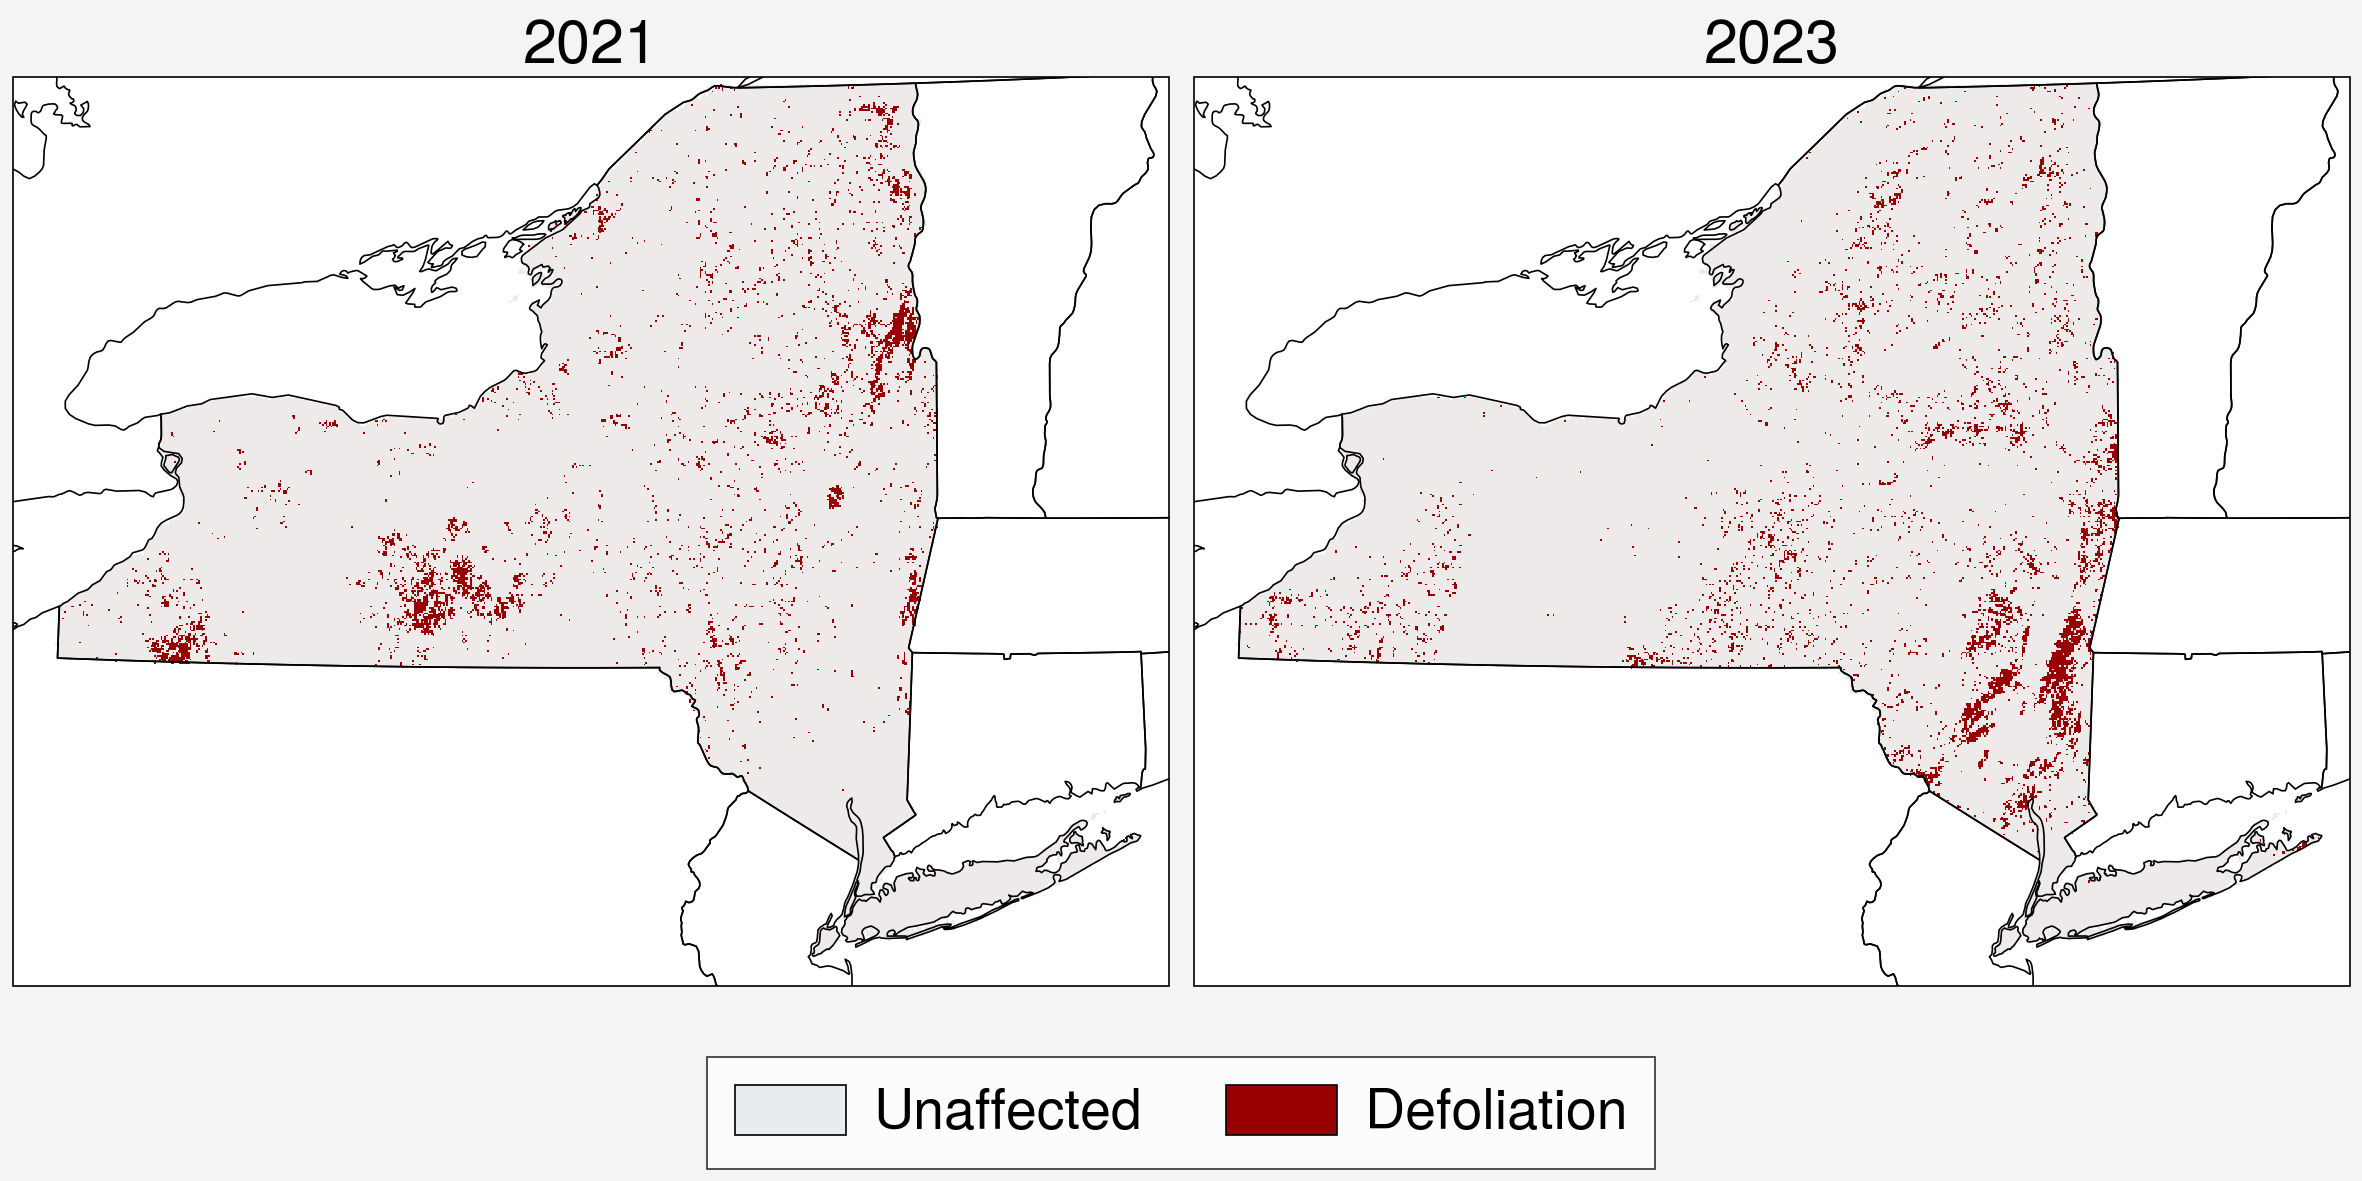

In [9]:
fig, axes = uplt.subplots(ncols=2, figsize=('300mm','150mm'), proj={(1, 2):dest_crs}, facecolor='white', fontsize=20)

#axes.format(abc='A.', abcloc='ul')

vmax = 1
vmin = 0
cmap = ['gray2', 'blood red']

# Yearly raster images
m = add_raster_data(axes[0], threshold_2021, bounds_2021, 2021, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[1], threshold_2023, bounds_2023, 2023, dest_crs, vmin, vmax, cmap)
    
no_patch = mpatches.Patch(facecolor=cmap[0], label='Unaffected', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Defoliation', edgecolor='black')
fig.legend(handles=[no_patch, defol_patch], loc='b', ncols=2, fontsize=20)

fig.savefig('./Figures/Yearly Images/outbreak_years_presentation.png')

### All years

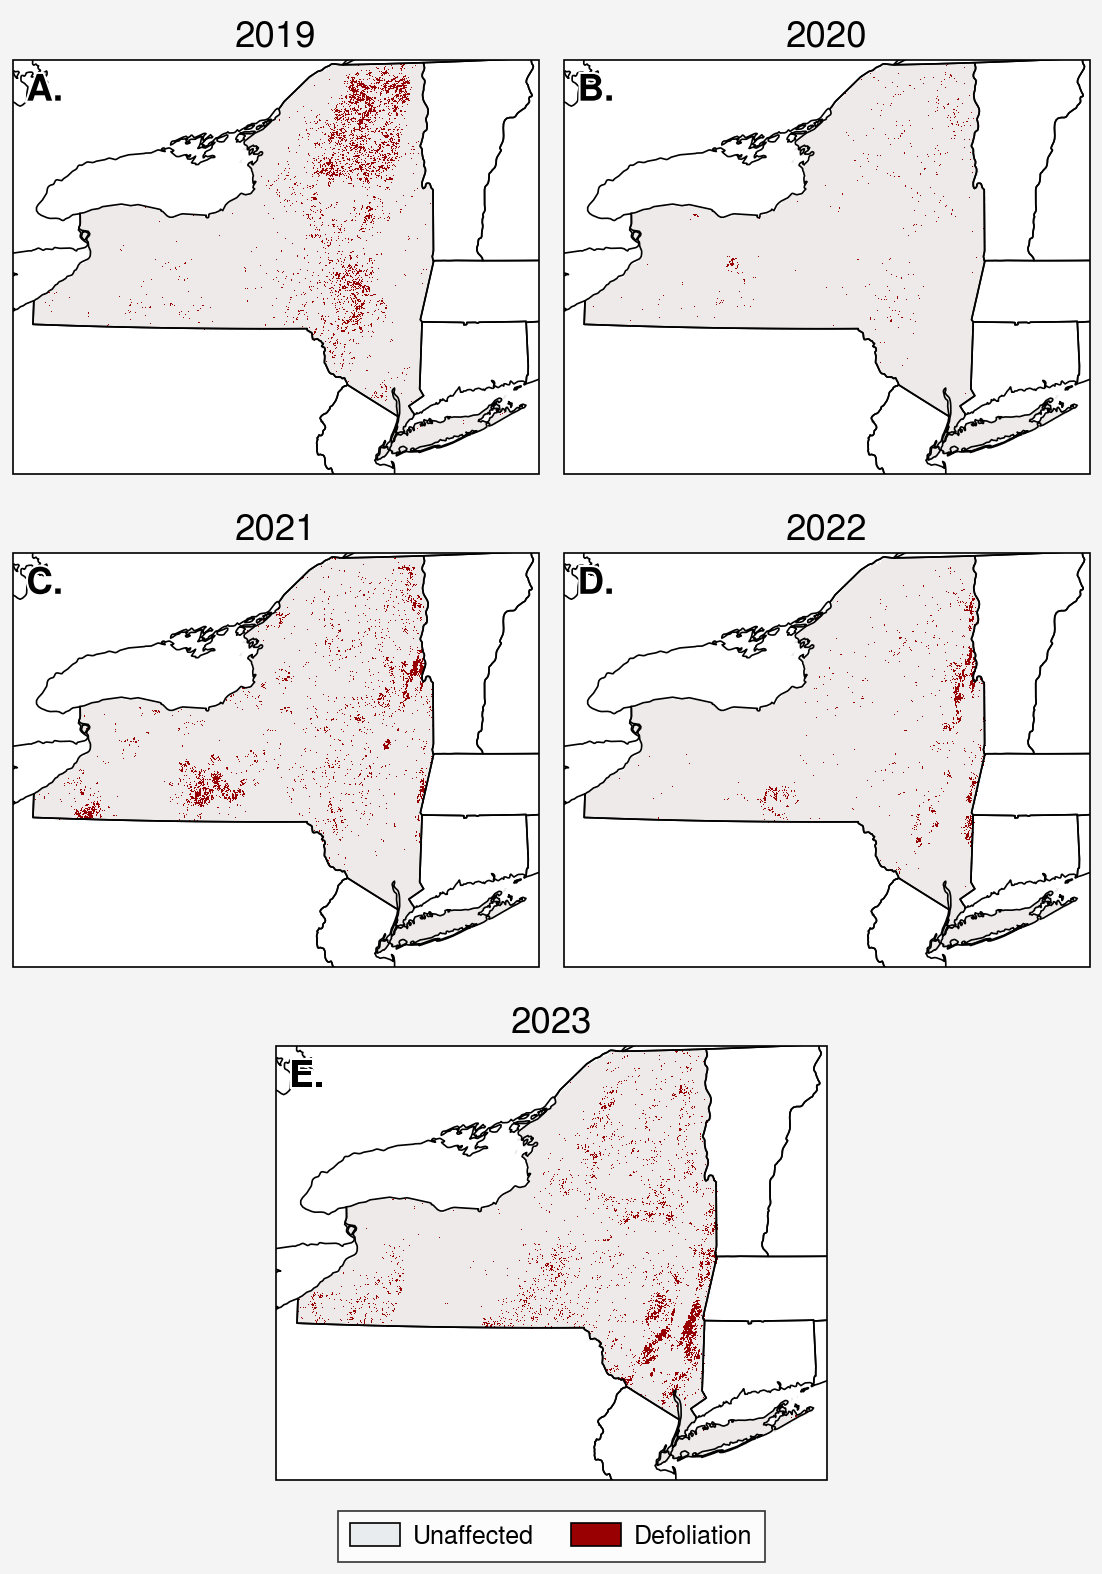

In [10]:
fig, axes = uplt.subplots(layout, figsize=('140mm','200mm'), proj={(1, 2, 3, 4, 5):dest_crs}, facecolor='white', fontsize=12)

axes.format(abc='A.', abcloc='ul')

vmax = 1
vmin = 0
cmap = ['gray2', 'blood red']

# Yearly raster images
m = add_raster_data(axes[0], threshold_2019, bounds_2019, 2019, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[1], threshold_2020, bounds_2020, 2020, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[2], threshold_2021, bounds_2021, 2021, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[3], threshold_2022, bounds_2022, 2022, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[4], threshold_2023, bounds_2023, 2023, dest_crs, vmin, vmax, cmap)
    
no_patch = mpatches.Patch(facecolor=cmap[0], label='Unaffected', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Defoliation', edgecolor='black')
fig.legend(handles=[no_patch, defol_patch], loc='b', ncols=2)

#fig.savefig('./Figures/Yearly Images/year_map_upscaled_V3.png')

### Yearly Masks (all years)

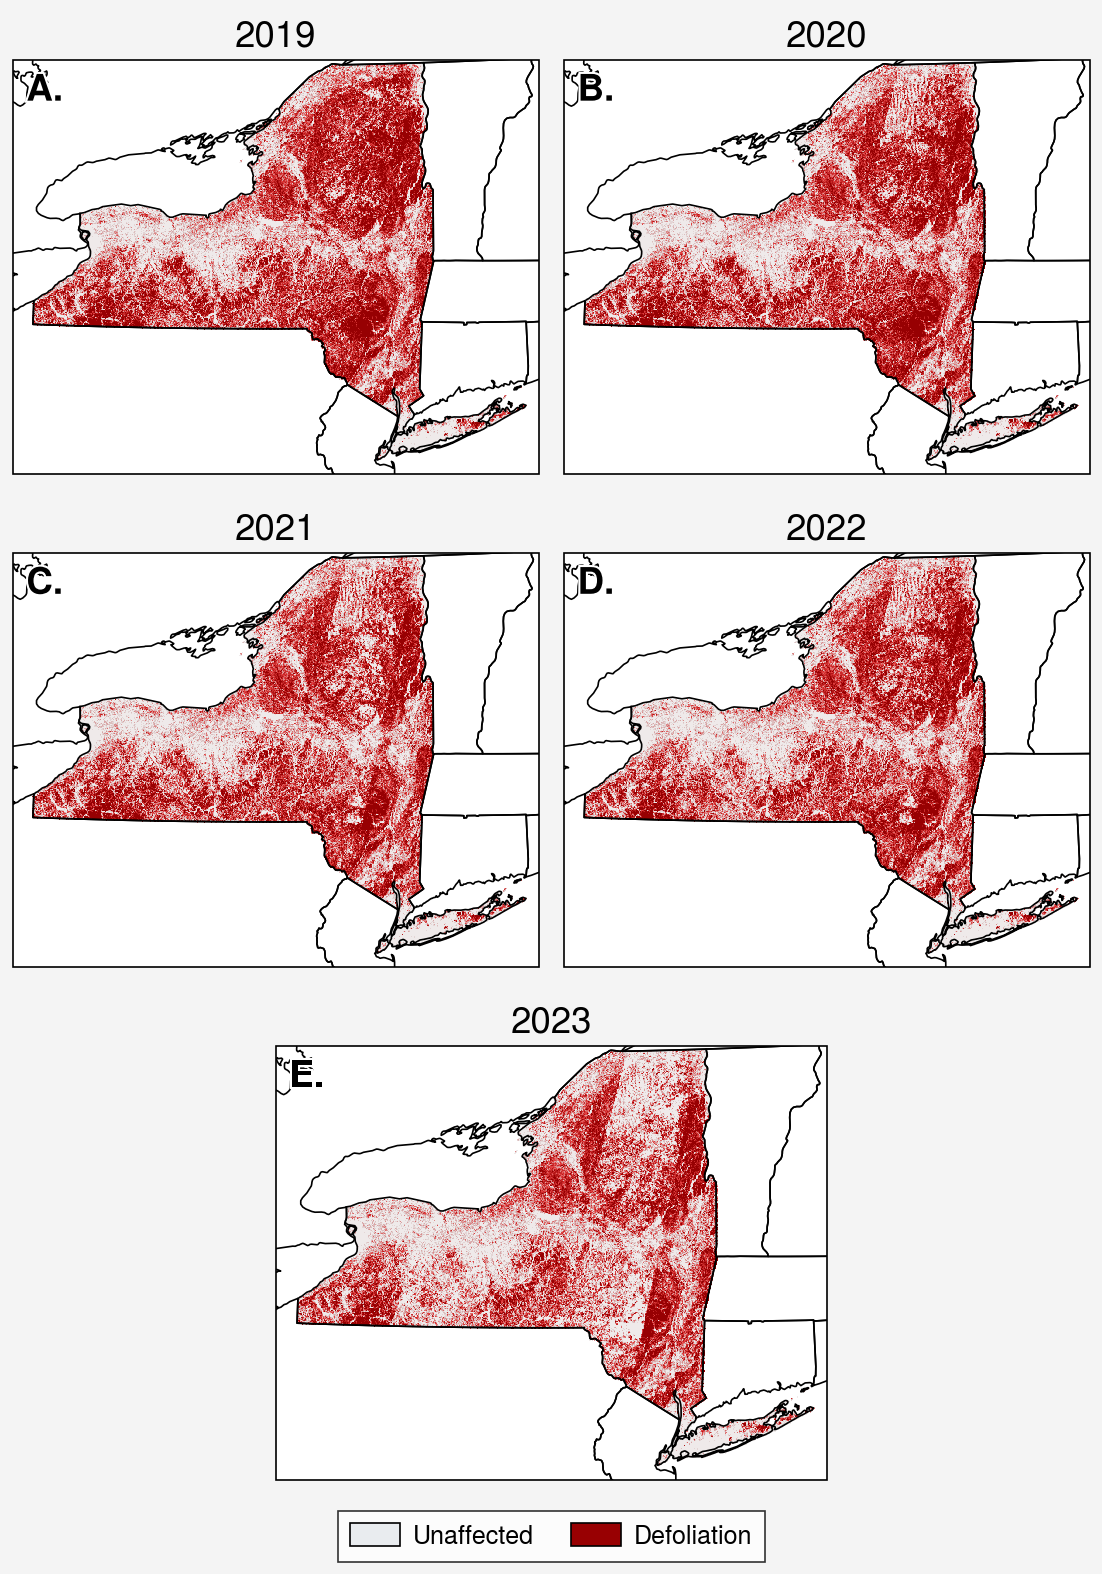

In [11]:
fig, axes = uplt.subplots(layout, figsize=('140mm','200mm'), proj=dest_crs, facecolor='white', fontsize=12)

axes.format(abc='A.', abcloc='ul')

vmax = 1
vmin = 0
cmap = ['gray2', 'blood red']

# Yearly raster images
m = add_raster_data(axes[0], image_2019[:, :, 1], bounds_2019, 2019, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[1], image_2020[:, :, 1], bounds_2020, 2020, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[2], image_2021[:, :, 1], bounds_2021, 2021, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[3], image_2022[:, :, 1], bounds_2022, 2022, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[4], image_2023[:, :, 1], bounds_2023, 2023, dest_crs, vmin, vmax, cmap)
    
no_patch = mpatches.Patch(facecolor=cmap[0], label='Unaffected', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Defoliation', edgecolor='black')
fig.legend(handles=[no_patch, defol_patch], loc='b', ncols=2)

#fig.savefig('./Figures/Yearly Images/year_map_upscaled_V3.png')

### 2020-2023

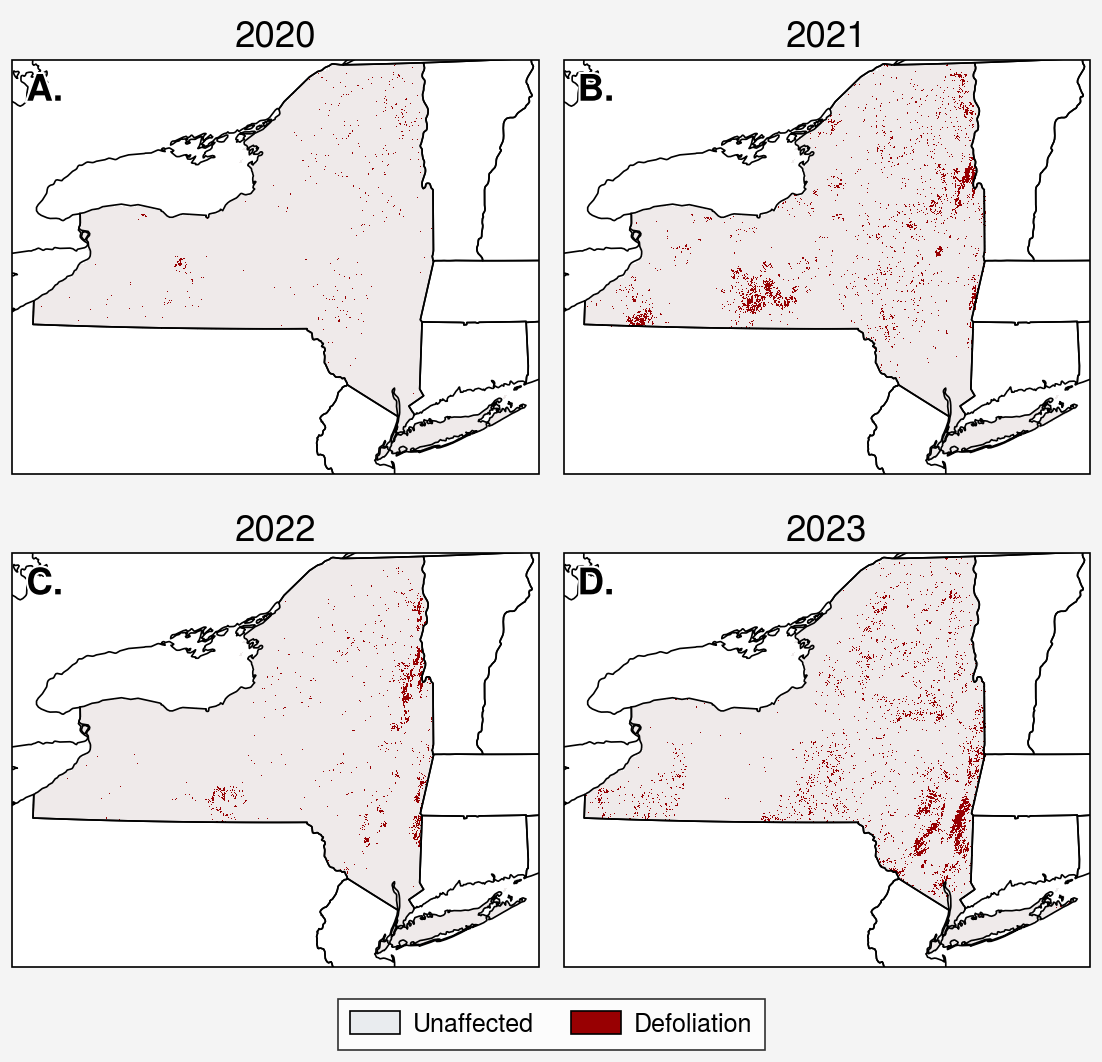

In [12]:
fig, axes = uplt.subplots(nrows=2, ncols=2, figsize=('140mm','135mm'), proj={(1, 2, 3, 4):dest_crs}, facecolor='white', fontsize=12)

axes.format(abc='A.', abcloc='ul')

vmax = 1
vmin = 0
cmap = ['gray2', 'blood red']

# Yearly raster images
add_raster_data(axes[0], threshold_2020, bounds_2020, 2020, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[1], threshold_2021, bounds_2021, 2021, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[2], threshold_2022, bounds_2022, 2022, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[3], threshold_2023, bounds_2023, 2023, dest_crs, vmin, vmax, cmap)
    
no_patch = mpatches.Patch(facecolor=cmap[0], label='Unaffected', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Defoliation', edgecolor='black')
fig.legend(handles=[no_patch, defol_patch], loc='b', ncols=2)

fig.savefig('./Figures/Yearly Images/year_map_upscaled_2020_to_2023.png')

In [39]:
trend = pd.read_csv('./Data/Yearly Images/yearly_trend.csv')
trend['area'] /= 1000000
trend = trend[~(trend['year'] == 2019)]
trend = trend.set_index(trend['year'])

In [40]:
trend

system:index         area  year                                    .geo
year                                                                         
2020             1   550.886555  2020  {"type":"MultiPoint","coordinates":[]}
2021             2  2114.403847  2021  {"type":"MultiPoint","coordinates":[]}
2022             3  1083.700323  2022  {"type":"MultiPoint","coordinates":[]}
2023             4  2497.850880  2023  {"type":"MultiPoint","coordinates":[]}

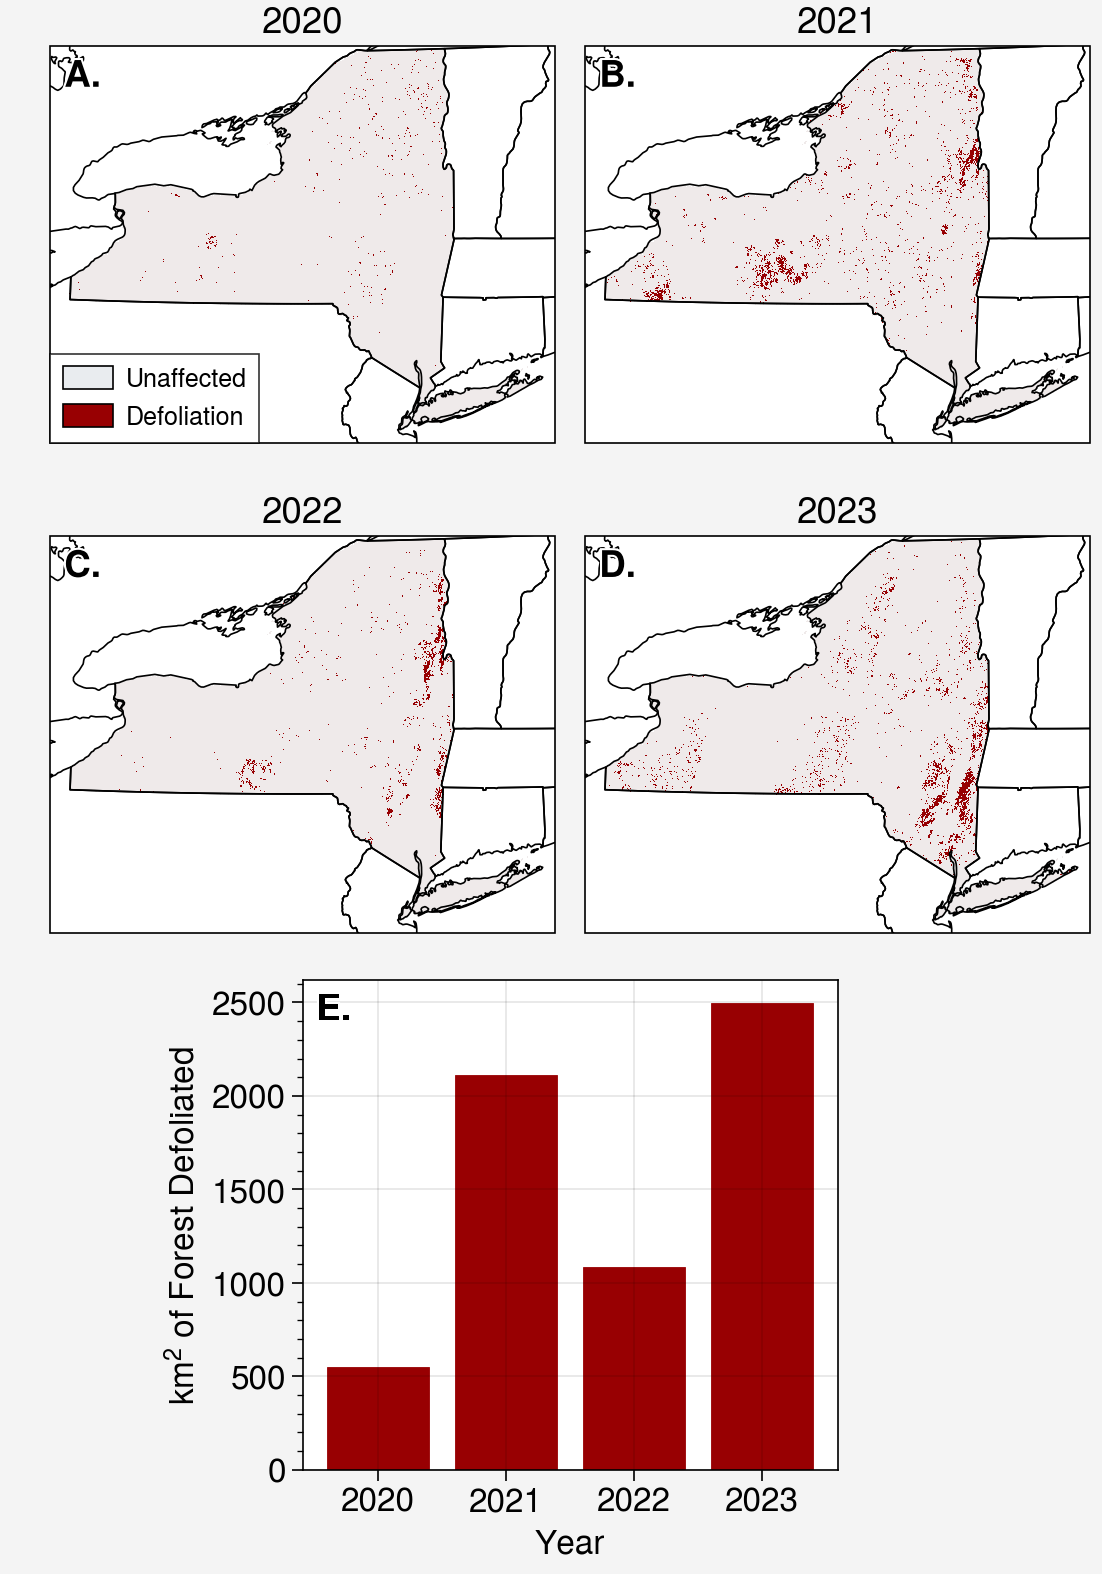

In [51]:
layout = [[1, 1, 2, 2,],
          [3, 3, 4, 4,],
          [0, 5, 5, 0,]]

fig, axes = uplt.subplots(layout, figsize=('140mm','200mm'), proj={(1, 2, 3, 4):dest_crs}, facecolor='white', fontsize=12)

axes.format(abc='A.', abcloc='ul')

vmax = 1
vmin = 0
cmap = ['gray2', 'blood red']

# Yearly raster images
add_raster_data(axes[0], threshold_2020, bounds_2020, 2020, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[1], threshold_2021, bounds_2021, 2021, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[2], threshold_2022, bounds_2022, 2022, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[3], threshold_2023, bounds_2023, 2023, dest_crs, vmin, vmax, cmap)

axes[4].bar(trend['area'], color=cmap[1])
axes[4].format(xlabel='Year', ylabel='km$^2$ of Forest Defoliated', xminorticks='none',)

    
no_patch = mpatches.Patch(facecolor=cmap[0], label='Unaffected', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Defoliation', edgecolor='black')
axes[0].legend(loc='lower left', handles=[no_patch, defol_patch],  ncols=1)

fig.savefig('./Figures/Yearly Images/year_map_upscaled_2020_to_2023.png')

### 2019

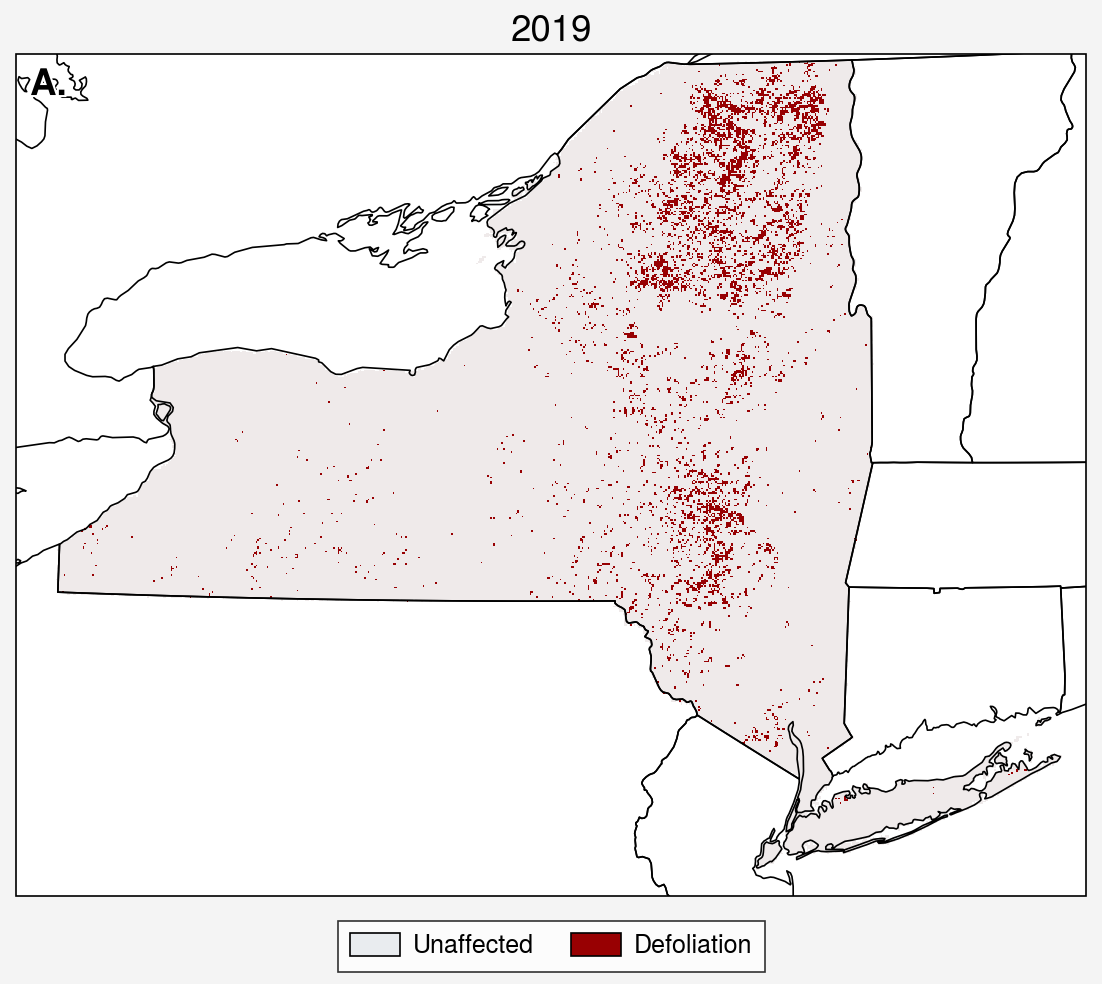

In [13]:
fig, axes = uplt.subplots(figsize=('140mm','125mm'), proj={(1):dest_crs}, facecolor='white', fontsize=12)

axes.format(abc='A.', abcloc='ul')

vmax = 1
vmin = 0
cmap = ['gray2', 'blood red']

# Yearly raster images
add_raster_data(axes[0], threshold_2019, bounds_2019, 2019, dest_crs, vmin, vmax, cmap)
    
no_patch = mpatches.Patch(facecolor=cmap[0], label='Unaffected', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Defoliation', edgecolor='black')
fig.legend(handles=[no_patch, defol_patch], loc='b', ncols=2)

fig.savefig('./Figures/Yearly Images/year_map_upscaled_2019.png')

### Aerial Survey Comparison

In [14]:
def confusion_classify(image, threshold):
    return np.where(np.isnan(image[:, :, 0]), np.nan,
            (np.where((threshold == 0) & (image[:, :, 4] == 0), 1, 0) +
             np.where((threshold == 1) & (image[:, :, 4] == 1), 2, 0) +
             np.where((threshold == 1) & (image[:, :, 4] == 0), 3, 0) +
             np.where((threshold == 0) & (image[:, :, 4] == 1), 4, 0)))

In [15]:
image_2019[:, :, 4] /= 2019
image_2020[:, :, 4] /= 2020
image_2021[:, :, 4] /= 2021
image_2022[:, :, 4] /= 2022
image_2023[:, :, 4] /= 2023

In [16]:
class_2019 = confusion_classify(image_2019, threshold_2019)
class_2020 = confusion_classify(image_2020, threshold_2020)
class_2021 = confusion_classify(image_2021, threshold_2021)
class_2022 = confusion_classify(image_2022, threshold_2022)
class_2023 = confusion_classify(image_2023, threshold_2023)

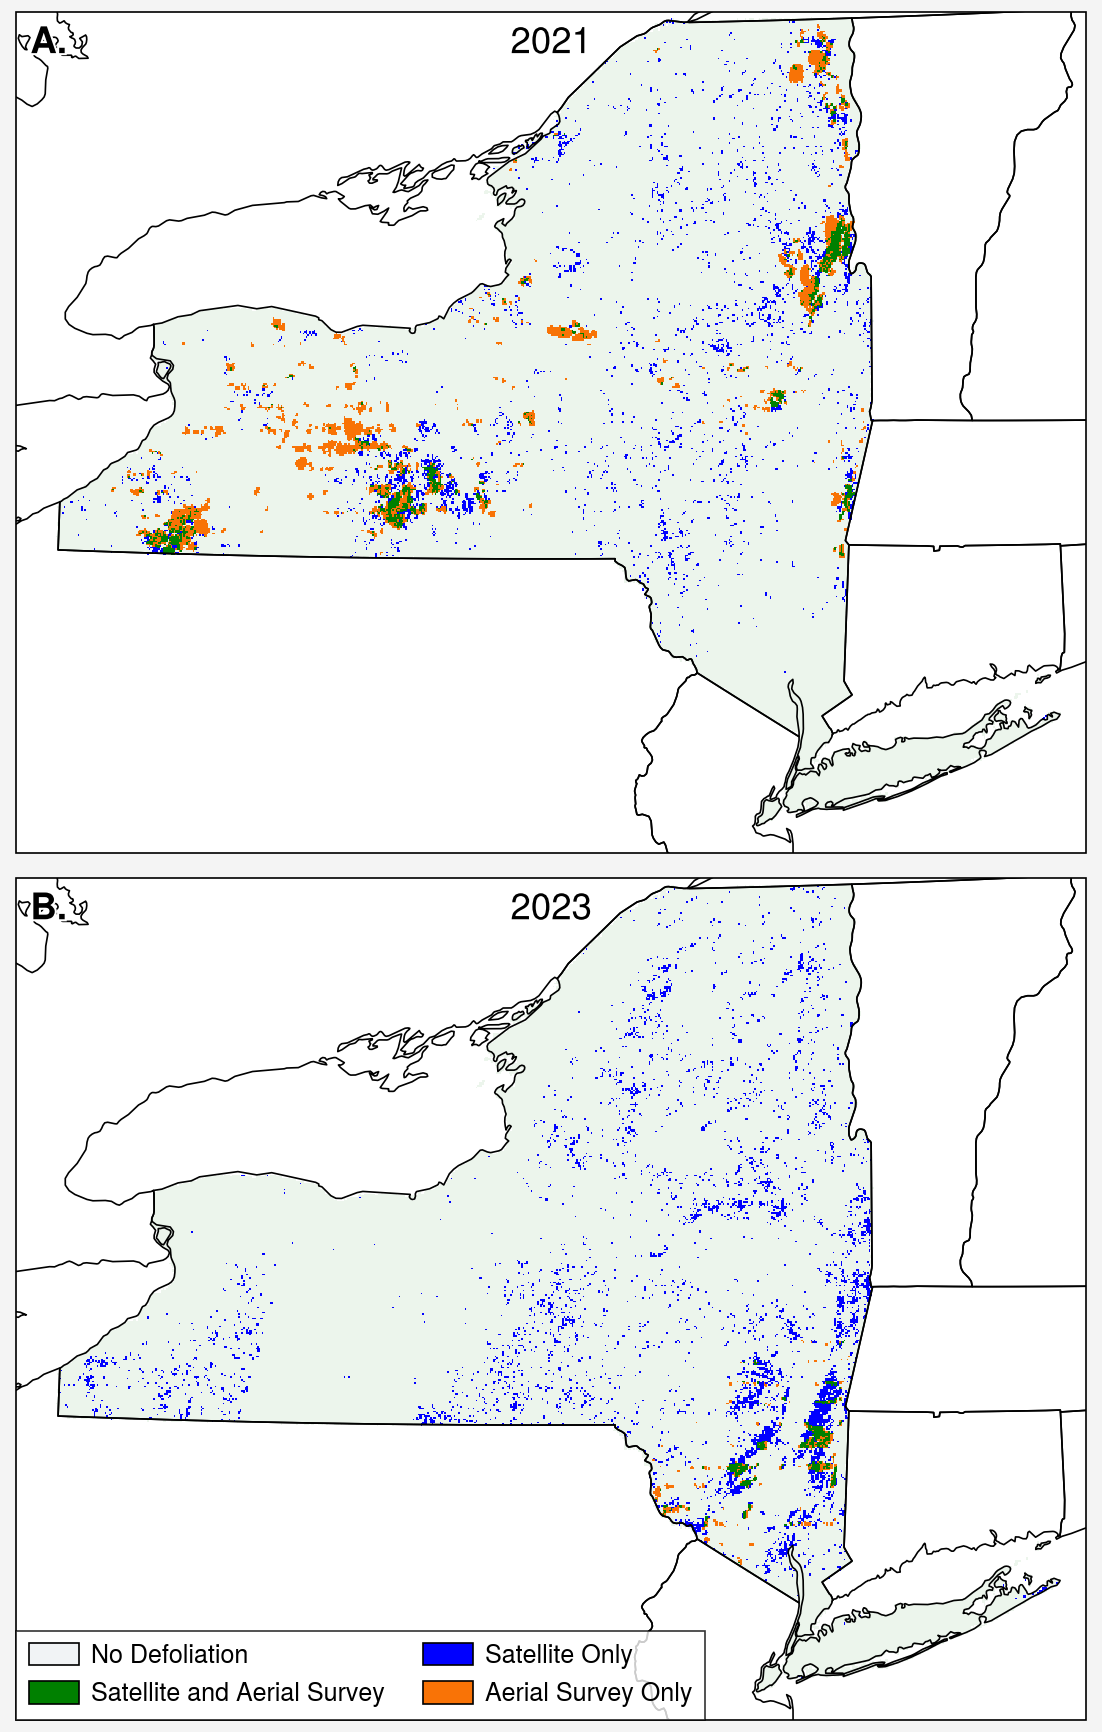

In [17]:
fig, axes = uplt.subplots(nrows=2, figsize=('140mm','220mm'), proj=dest_crs, facecolor='white', fontsize=12)

axes.format(abc='A.', abcloc='upper left')

cmap = ['gray1', 'green', 'blue', 'orange']
m = add_raster_data(axes[0], class_2021, bounds_2021, '', dest_crs, 1, 4, cmap)
axes[0].format(uctitle='2021')
add_raster_data(axes[1], class_2023, bounds_2023, '', dest_crs, 1, 4, cmap)
axes[1].format(uctitle='2023')

no_patch = mpatches.Patch(facecolor=cmap[0], label='No Defoliation', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Satellite and Aerial Survey', edgecolor='black')
sat_patch = mpatches.Patch(facecolor=cmap[2], label='Satellite Only', edgecolor='black')
as_patch = mpatches.Patch(facecolor=cmap[3], label='Aerial Survey Only', edgecolor='black')
axes[1].legend(handles=[no_patch, sat_patch, defol_patch, as_patch], loc='ll', ncols=2)

fig.savefig('./Figures/Defol_Eval/statewide_comparison.png')

## 3-mask

In [18]:
cutoff = 0.1

threshold_2019 = classify(image_2019[:, :, 2], cutoff)
threshold_2020 = classify(image_2020[:, :, 2], cutoff)
threshold_2021 = classify(image_2021[:, :, 2], cutoff)
threshold_2022 = classify(image_2022[:, :, 2], cutoff)
threshold_2023 = classify(image_2023[:, :, 2], cutoff)

### All years

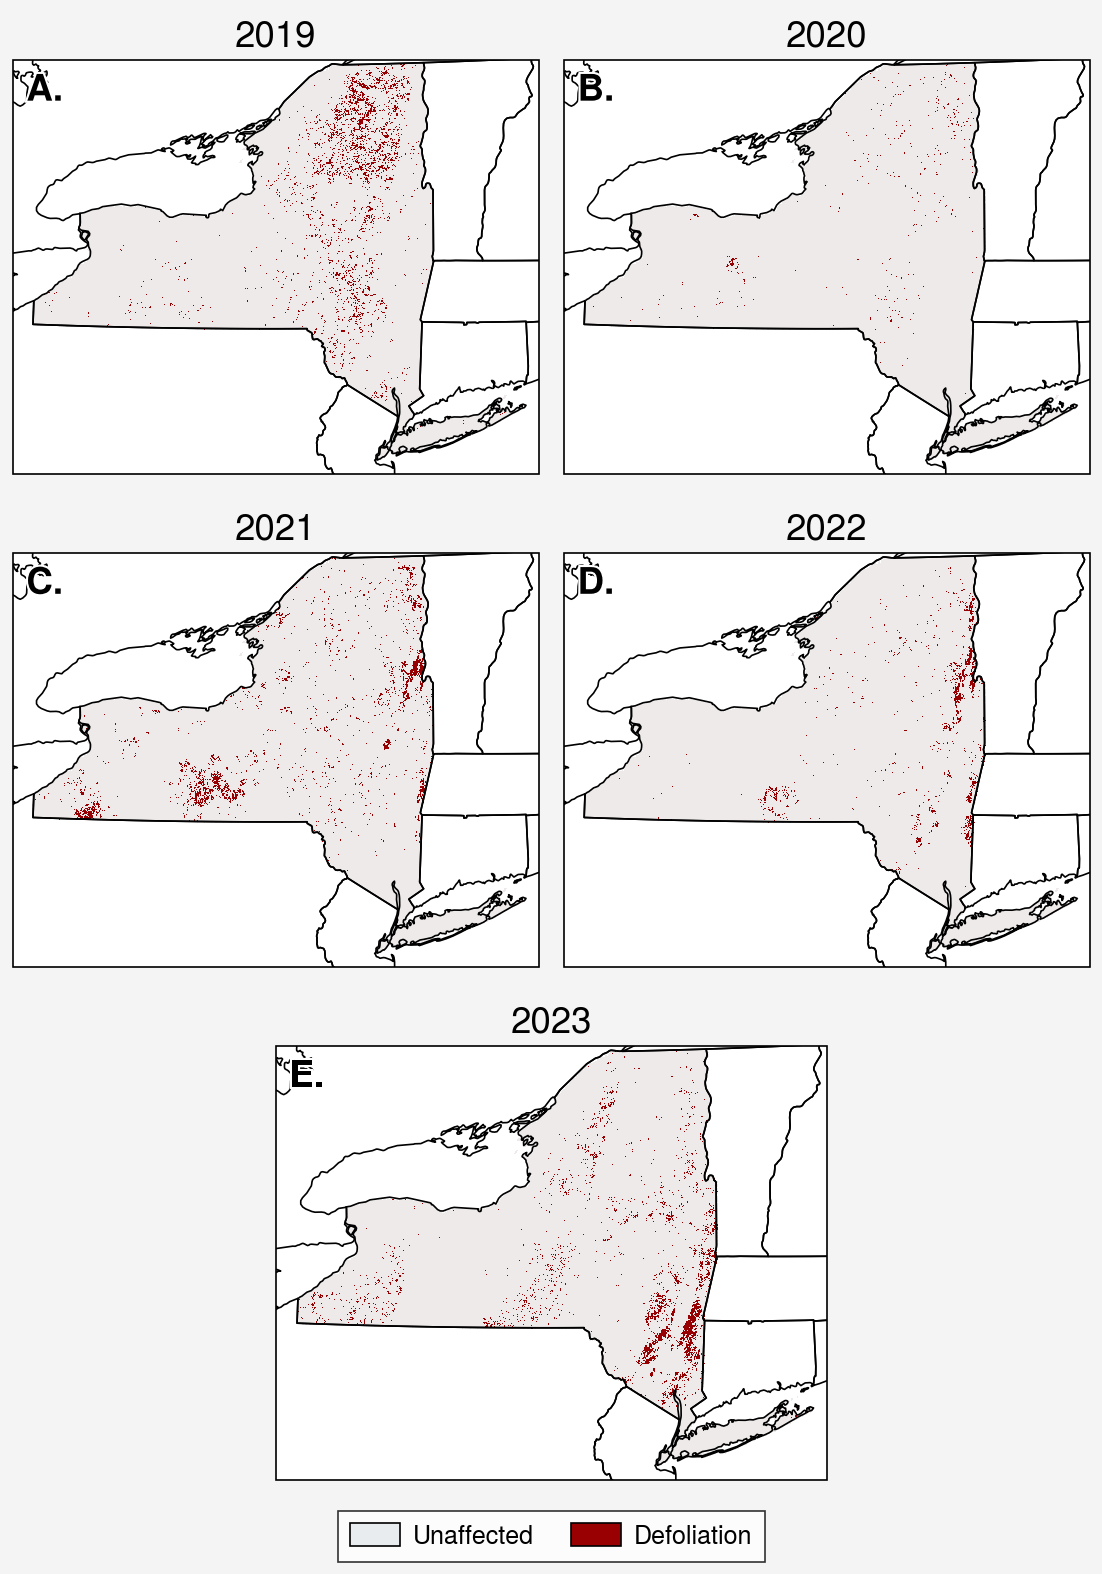

In [19]:
fig, axes = uplt.subplots(layout, figsize=('140mm','200mm'), proj=dest_crs, facecolor='white', fontsize=12)

axes.format(abc='A.', abcloc='ul')

vmax = 1
vmin = 0
cmap = ['gray2', 'blood red']

# Yearly raster images
m = add_raster_data(axes[0], threshold_2019, bounds_2019, 2019, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[1], threshold_2020, bounds_2020, 2020, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[2], threshold_2021, bounds_2021, 2021, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[3], threshold_2022, bounds_2022, 2022, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[4], threshold_2023, bounds_2023, 2023, dest_crs, vmin, vmax, cmap)
    
no_patch = mpatches.Patch(facecolor=cmap[0], label='Unaffected', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Defoliation', edgecolor='black')
fig.legend(handles=[no_patch, defol_patch], loc='b', ncols=2)

#fig.savefig('./Figures/Yearly Images/year_map_upscaled_V3.png')

### 2020-2023

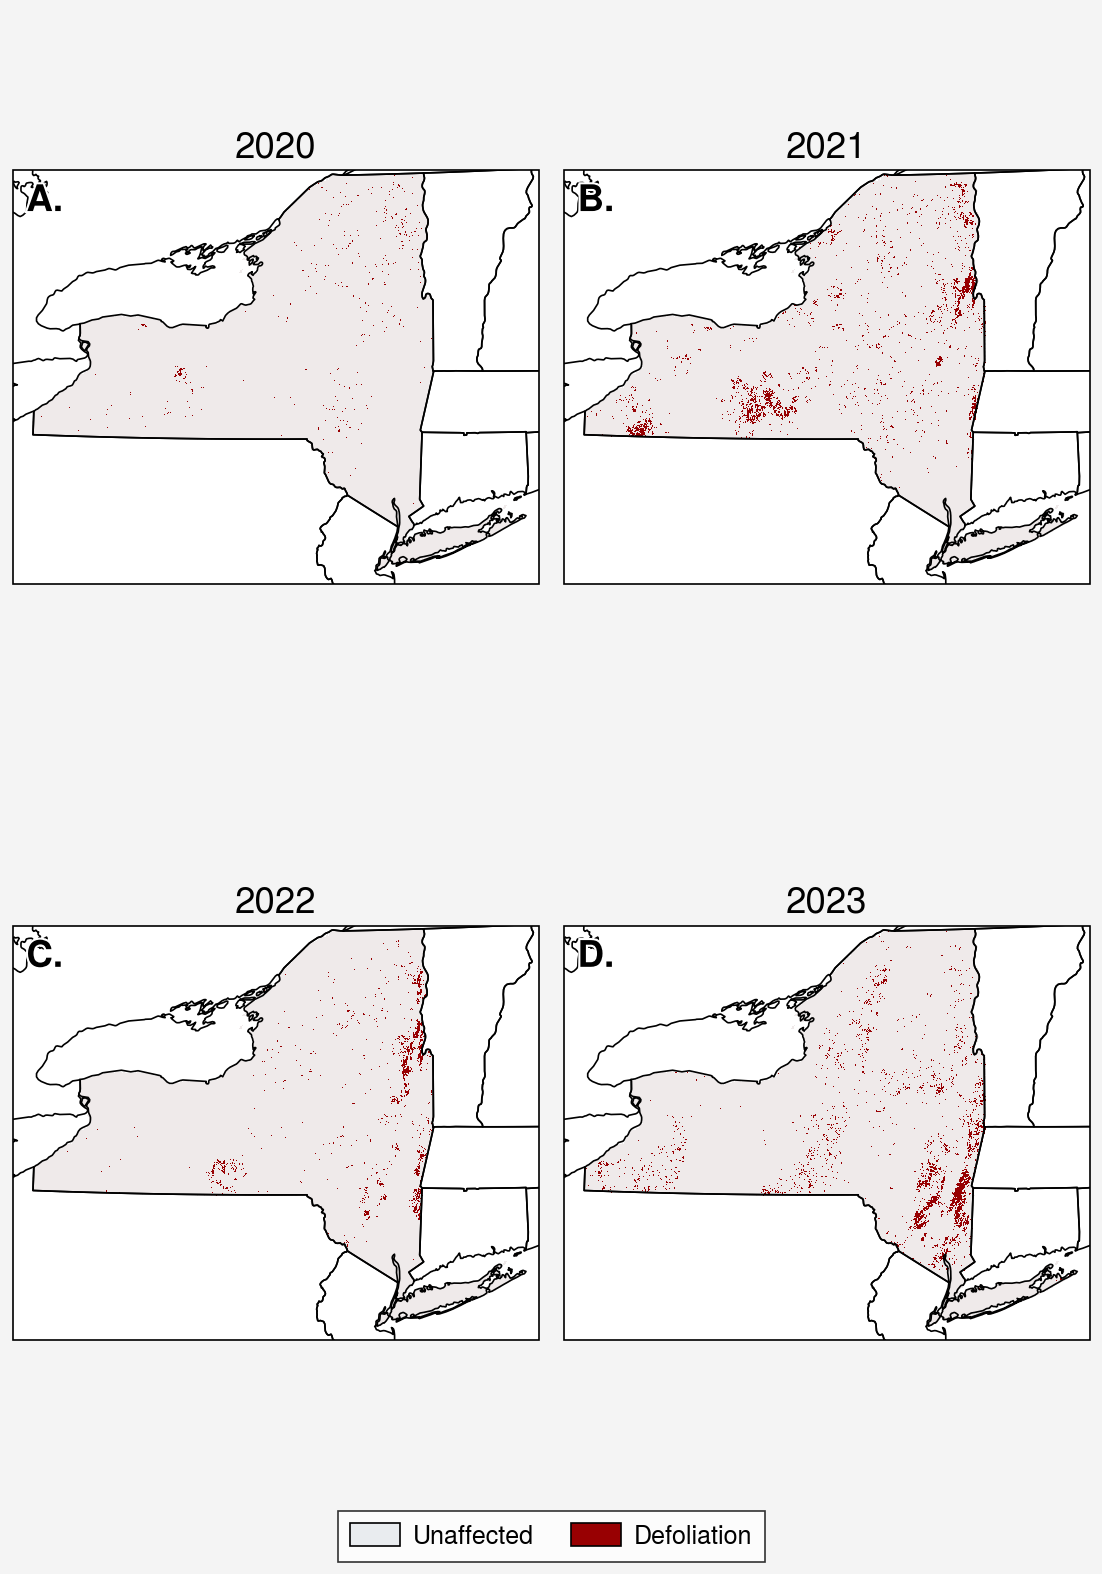

In [20]:
fig, axes = uplt.subplots(nrows=2, ncols=2, figsize=('140mm','200mm'), proj=dest_crs, facecolor='white', fontsize=12)

axes.format(abc='A.', abcloc='ul')

vmax = 1
vmin = 0
cmap = ['gray2', 'blood red']

# Yearly raster images
add_raster_data(axes[0], threshold_2020, bounds_2020, 2020, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[1], threshold_2021, bounds_2021, 2021, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[2], threshold_2022, bounds_2022, 2022, dest_crs, vmin, vmax, cmap)

add_raster_data(axes[3], threshold_2023, bounds_2023, 2023, dest_crs, vmin, vmax, cmap)
    
no_patch = mpatches.Patch(facecolor=cmap[0], label='Unaffected', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Defoliation', edgecolor='black')
fig.legend(handles=[no_patch, defol_patch], loc='b', ncols=2)

#fig.savefig('./Figures/Yearly Images/year_map_upscaled_V3.png')

### Aerial Survey Compare

In [21]:
class_2019 = confusion_classify(image_2019, threshold_2019)
class_2020 = confusion_classify(image_2020, threshold_2020)
class_2021 = confusion_classify(image_2021, threshold_2021)
class_2022 = confusion_classify(image_2022, threshold_2022)
class_2023 = confusion_classify(image_2023, threshold_2023)

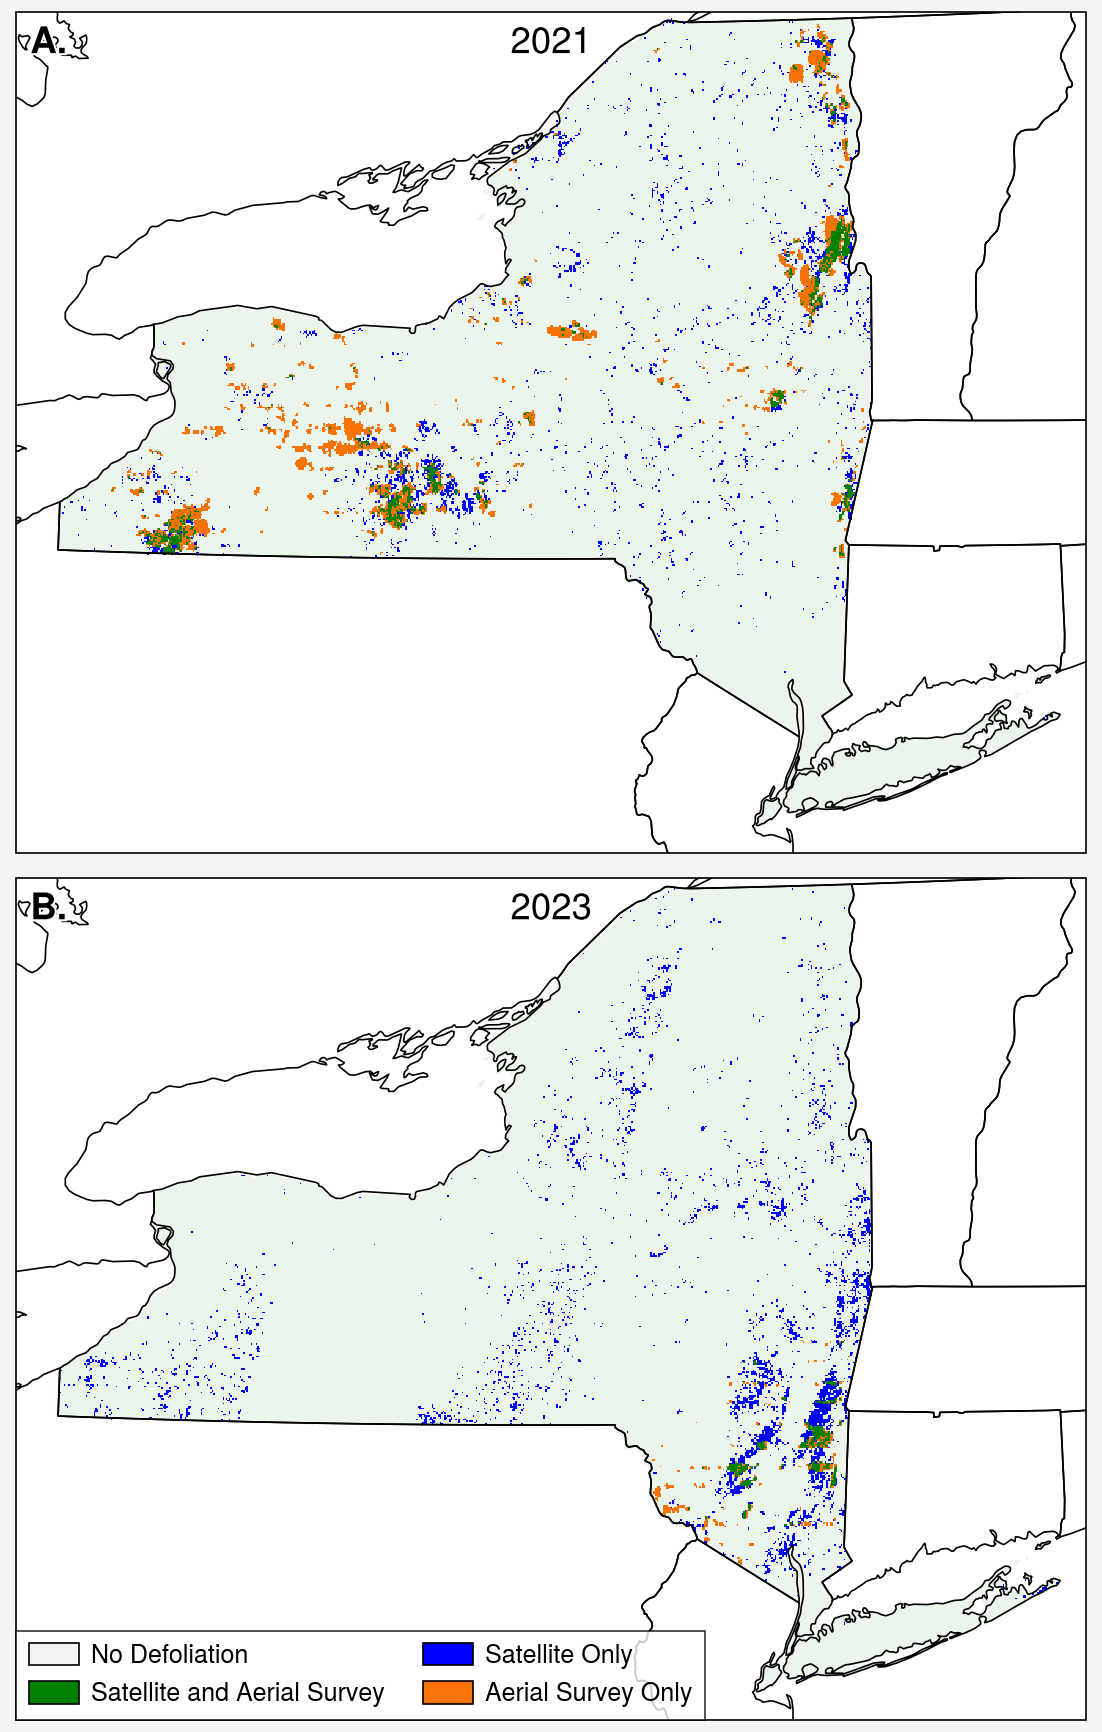

In [22]:
fig, axes = uplt.subplots(nrows=2, figsize=('140mm','220mm'), proj=dest_crs, facecolor='white', fontsize=12)

axes.format(abc='A.', abcloc='upper left')

cmap = ['gray1', 'green', 'blue', 'orange']
m = add_raster_data(axes[0], class_2021, bounds_2021, '', dest_crs, 1, 4, cmap)
axes[0].format(uctitle='2021')
add_raster_data(axes[1], class_2023, bounds_2023, '', dest_crs, 1, 4, cmap)
axes[1].format(uctitle='2023')

no_patch = mpatches.Patch(facecolor=cmap[0], label='No Defoliation', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Satellite and Aerial Survey', edgecolor='black')
sat_patch = mpatches.Patch(facecolor=cmap[2], label='Satellite Only', edgecolor='black')
as_patch = mpatches.Patch(facecolor=cmap[3], label='Aerial Survey Only', edgecolor='black')
axes[1].legend(handles=[no_patch, sat_patch, defol_patch, as_patch], loc='ll', ncols=2)

fig.savefig('./Figures/Defol_Eval/statewide_comparison.png')

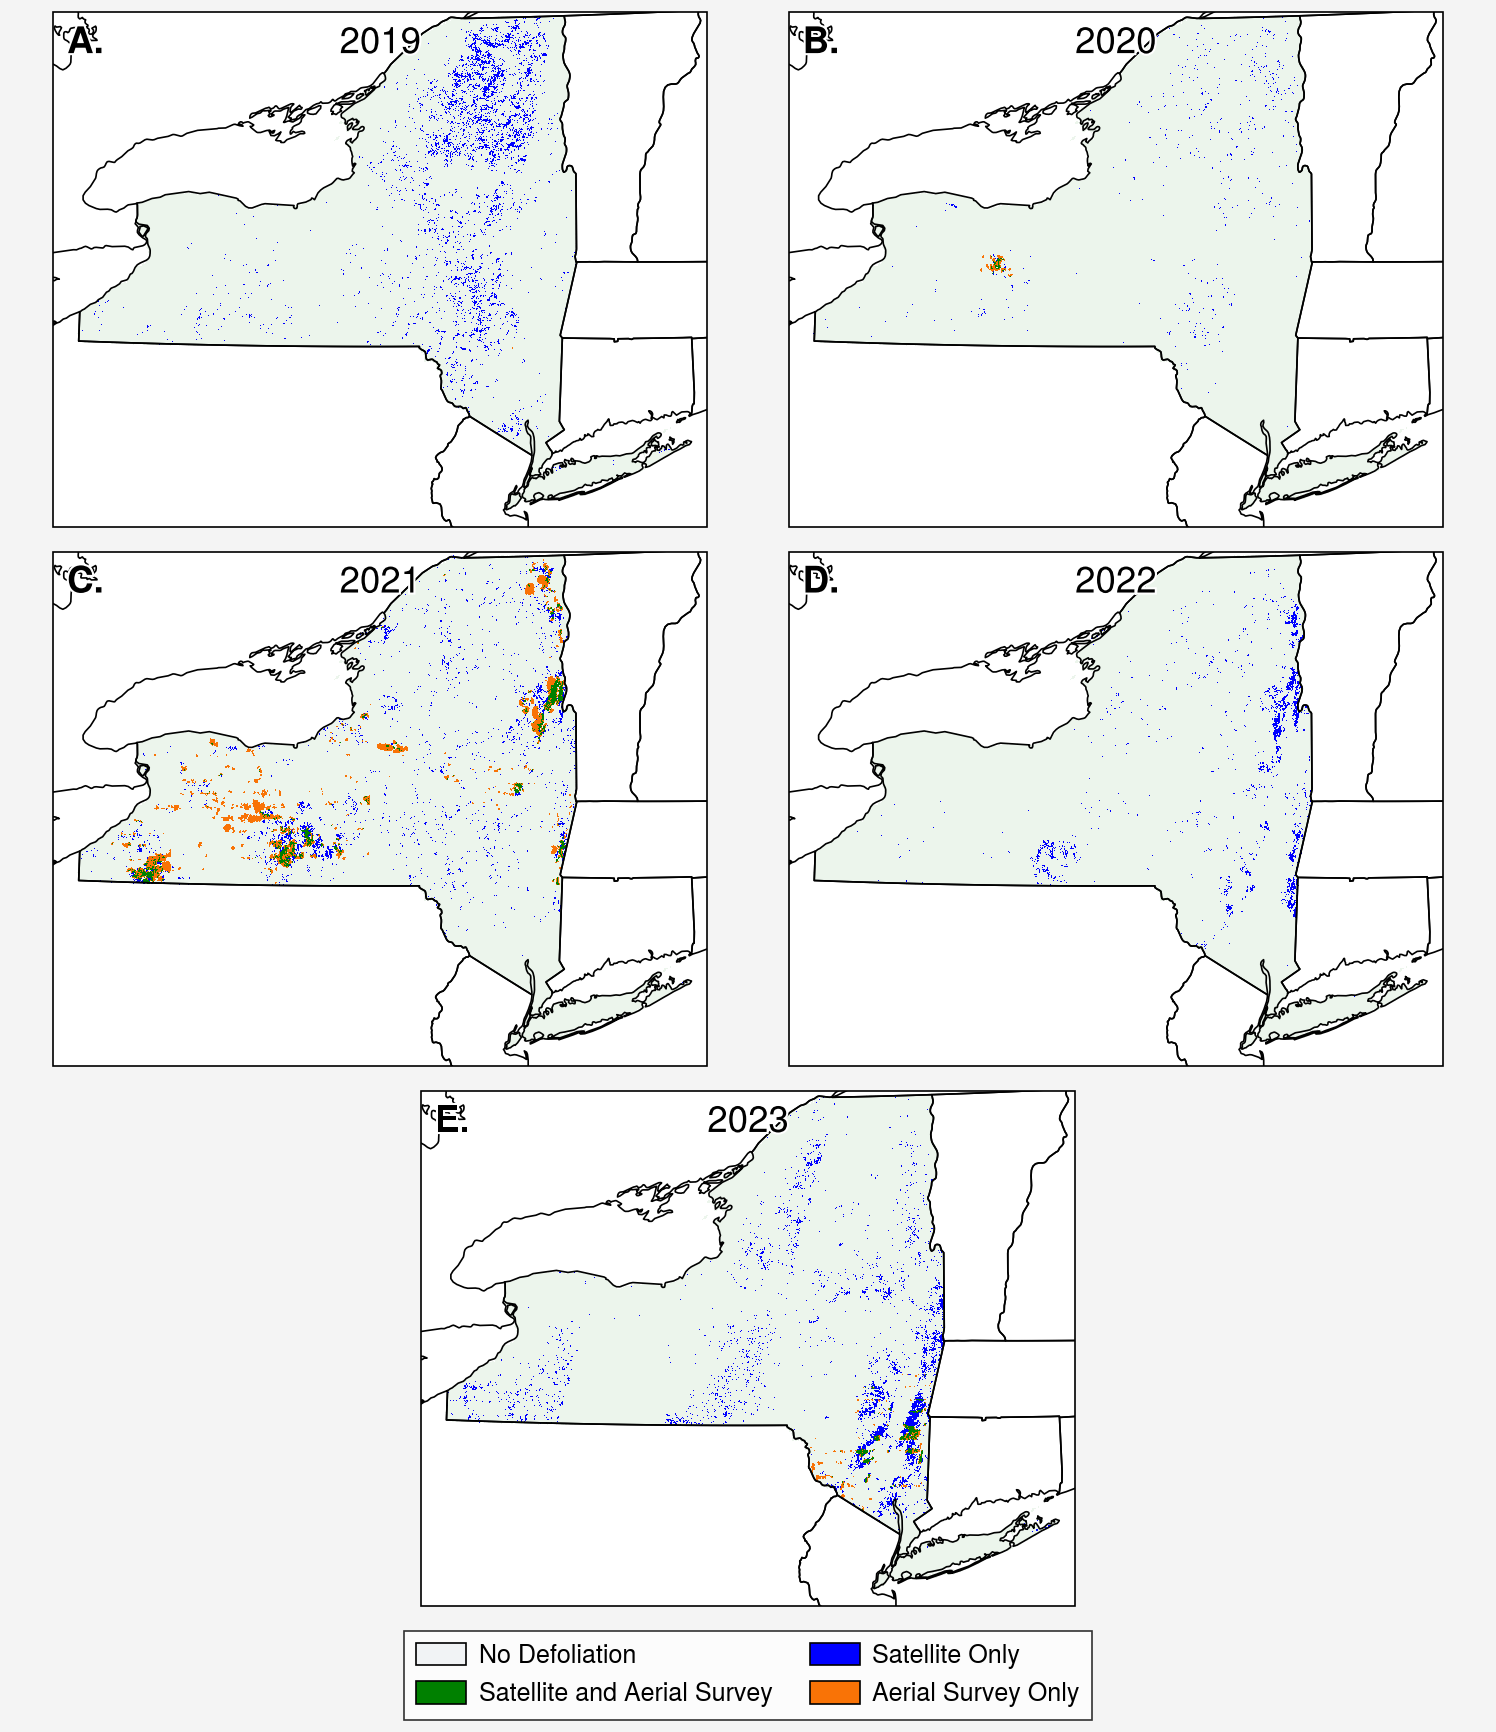

In [23]:
fig, axes = uplt.subplots(layout, figsize=('190mm','220mm'), proj=dest_crs, facecolor='white', fontsize=12)

axes.format(abc='A.', abcloc='upper left')

cmap = ['gray1', 'green', 'blue', 'orange']
m = add_raster_data(axes[0], class_2019, bounds_2019, '', dest_crs, 1, 4, cmap)
axes[0].format(uctitle='2019')
add_raster_data(axes[1], class_2020, bounds_2020, '', dest_crs, 1, 4, cmap)
axes[1].format(uctitle='2020')
add_raster_data(axes[2], class_2021, bounds_2021, '', dest_crs, 1, 4, cmap)
axes[2].format(uctitle='2021')
add_raster_data(axes[3], class_2022, bounds_2022, '', dest_crs, 1, 4, cmap)
axes[3].format(uctitle='2022')
add_raster_data(axes[4], class_2023, bounds_2023, '', dest_crs, 1, 4, cmap)
axes[4].format(uctitle='2023')


no_patch = mpatches.Patch(facecolor=cmap[0], label='No Defoliation', edgecolor='black')
defol_patch = mpatches.Patch(facecolor=cmap[1], label='Satellite and Aerial Survey', edgecolor='black')
sat_patch = mpatches.Patch(facecolor=cmap[2], label='Satellite Only', edgecolor='black')
as_patch = mpatches.Patch(facecolor=cmap[3], label='Aerial Survey Only', edgecolor='black')
fig.legend(handles=[no_patch, sat_patch, defol_patch, as_patch], loc='bottom', ncols=2)

fig.savefig('./Figures/Defol_Eval/statewide_comparison_all_years.png')

## Yearly Trends

In [24]:
trend = pd.read_csv('./Data/Yearly Images/yearly_trend.csv')
trend['area'] /= 1000000
trend = trend[~(trend['year'] == 2019)]

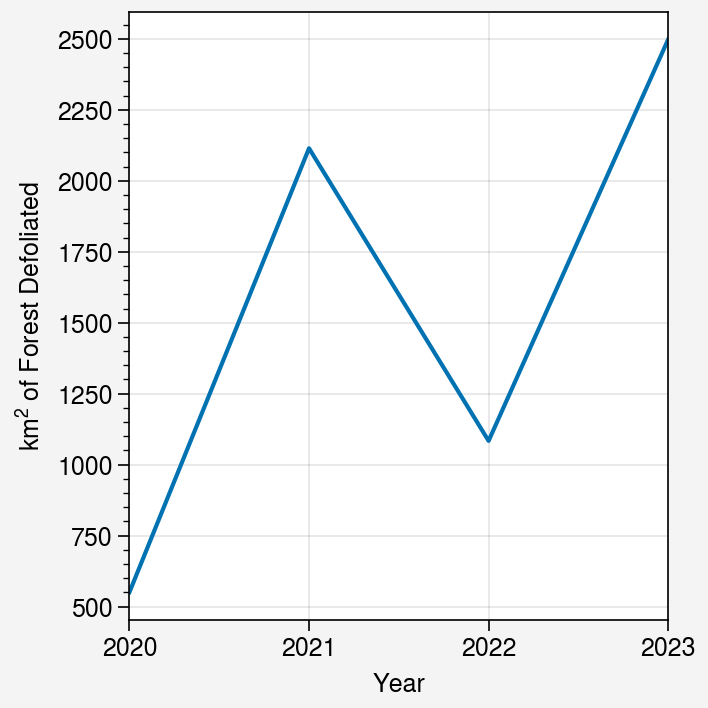

In [25]:
fig, ax = uplt.subplots(figsize=('90mm','90mm'))

ax.plot(trend['year'], trend['area'])
ax.format(xlabel='Year', ylabel='km$^2$ of Forest Defoliated', xminorticks='none', xlocator=[2020, 2021, 2022, 2023])

fig.savefig('./Figures/Yearly Images/yearly_trend.png')

In [26]:
trend.loc[(trend['year'] >= 2020) & (trend['year'] <= 2023), 'area'].mean()

np.float64(1561.71040127451)

In [27]:
trend

system:index         area  year                                    .geo
1             1   550.886555  2020  {"type":"MultiPoint","coordinates":[]}
2             2  2114.403847  2021  {"type":"MultiPoint","coordinates":[]}
3             3  1083.700323  2022  {"type":"MultiPoint","coordinates":[]}
4             4  2497.850880  2023  {"type":"MultiPoint","coordinates":[]}